# chunking large tif files and writing to files

In [22]:
## Import libraries

# general
import os
import gc
import glob
import math
import numpy as np
import itertools
import slidingwindow as sw

# rasters
import rasterio
from rasterio.mask import mask

# shapes
import fiona
import shapefile
import shapely
from shapely.geometry import shape, Polygon, box, MultiPolygon
from shapely.ops import cascaded_union, unary_union

# for transormations
import pyproj
from shapely.ops import transform
from functools import partial

# working with images
from PIL import Image
from skimage import exposure
from skimage.io import imsave, imread

# visualizations
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [23]:
# load helper functions

def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return int(UTM_EPSG_code)

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list

In [31]:
# set parameters
plot_results = True
run_all = False

chunk_size_pix = 400
overlap_frac = 0.2
label = 'tree'

# set bands https://sites.google.com/a/daffodilsw.com/green-city-watch/project-guidelines/data
# [r g b]
band_list = [3,2,1] 

# define paths with raster data
rasters_file_path = '../../data/data_merged/tif/*.tif'

# define paths with contrast polygon (area with trees)
contrast_file_path = '../../data/data_merged/contrast/*.shp'

# output folder
output_path = '../../data/data_merged/training_data/test_chunks_only/'

In [32]:
# find all files in folders for specific classes
# find current working directory 
cwd = os.getcwd()

# find files in raster folder
raster_files = glob.glob(rasters_file_path)
raster_files
# load raster data
dataset = rasterio.open(raster_files[0])


In [33]:
## get raster bbox
# convert bounds to polygon
x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
poly_raster_bounds = Polygon([(x_min_data, y_min_data), 
                              (x_min_data, y_max_data), 
                              (x_max_data, y_max_data), 
                              (x_max_data, y_min_data)])


# get raster metadata

x_pix_size_m = dataset.meta['transform'][0]
y_pix_size_m = dataset.meta['transform'][4]

x_raster_size_pix = dataset.meta['width']
y_raster_size_pix = dataset.meta['height']

In [34]:
# Generate the set of windows
windows = sw.generate(np.rot90(np.fliplr(dataset.read().T)), sw.DimOrder.HeightWidthChannel, chunk_size_pix, overlap_frac)

In [35]:
## calculate band min max for specific bands base on selected area
# find files in shapefile folder
contrast_shape_files = glob.glob(contrast_file_path)
contrast_valid_shape_list = check_valid_geometries(contrast_shape_files[0])

# convert list to shapely MultiPolgyons
contrast_shape = shape(contrast_valid_shape_list[0]['geometry'])

out_img_chunk, out_transform_chunk = mask(dataset, shapes=[contrast_shape], crop=True)

img_plot_raw = out_img_chunk[band_list,:,:]
img_plot = np.rot90(np.fliplr(img_plot_raw.T))

band_minmax = []

for band in range(3):
    p_1, p_2 = np.percentile(img_plot[:,:,band], (2, 98))

    band_minmax.append([p_1, p_2])
    
band_minmax

[[735.0, 1469.0], [904.0, 1566.0], [1141.0, 1798.0]]

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


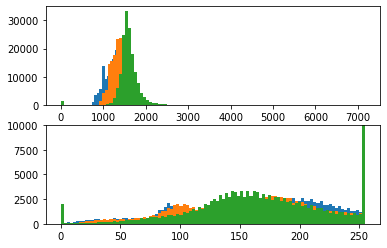

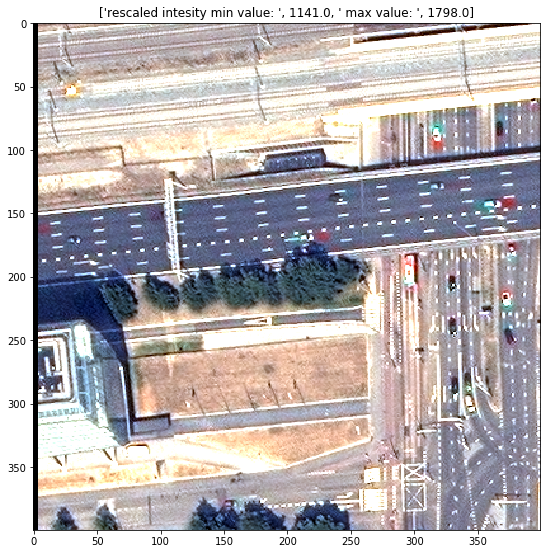

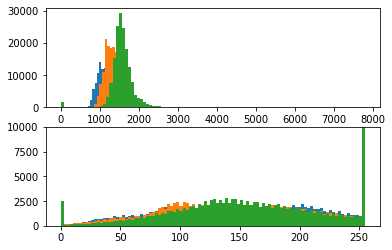

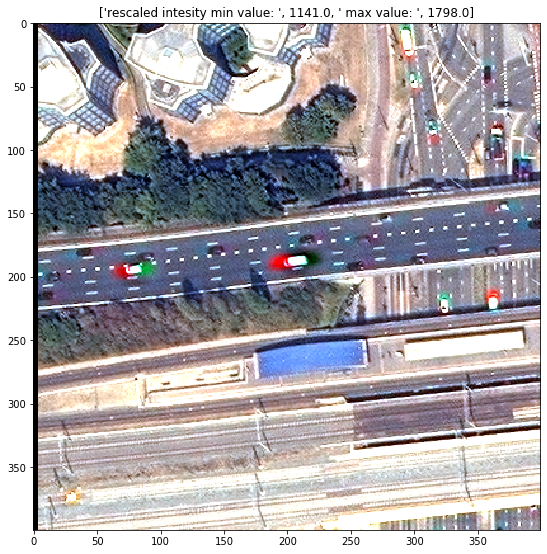

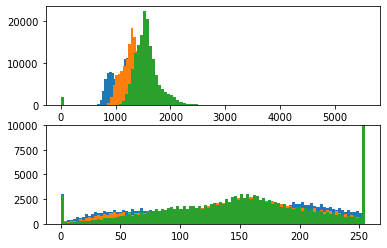

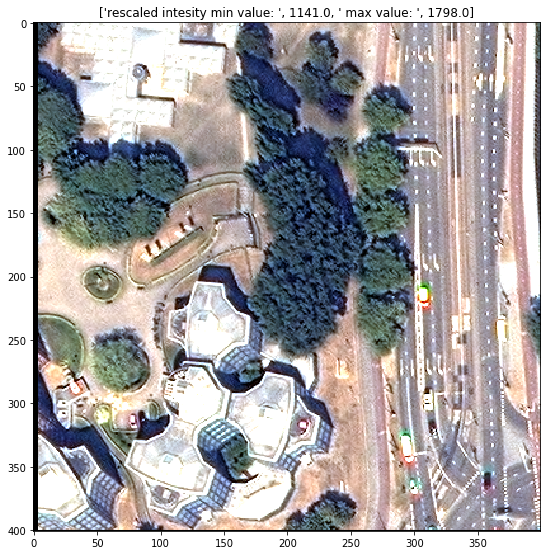

In [36]:
# loop over chunks 

if run_all:
    run_range = range(len(windows))
else:
    run_range = range(3)

for i in tqdm(run_range):

        # convert chunk coordinates to bbox
        x_min = (windows[i].x * x_pix_size_m) + x_min_data
        x_max = ((windows[i].x + windows[i].w) * x_pix_size_m) + x_min_data
        y_min = (windows[i].y * abs(y_pix_size_m)) + y_min_data
        y_max = ((windows[i].y + windows[i].h) * abs(y_pix_size_m)) + y_min_data
    
        # read dataset
        dataset = rasterio.open(raster_files[0])
        x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
        
        # clip raster file
        poly_chunk_bounds = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]) 
        out_img_chunk, out_transform_chunk = mask(dataset, shapes=[poly_chunk_bounds], crop=True)
          
        
        # get band data from raster and transform
        img_plot_raw = out_img_chunk[band_list,:,:]
        img_plot = np.rot90(np.fliplr(img_plot_raw.T))
        img_plot_enhance = np.array(img_plot, copy=True)
    
        ##### tif file #####
        # generate tiff profile 
        profile = dataset.profile
        profile['transform'] = out_transform_chunk
        profile['width'] = windows[i].w
        profile['height'] = windows[i].h
        
        # write tif file
        file_path_tif = '{0}example_{1:03d}.tif'.format(output_path,i)
        file_name_tif = 'example_{0:03d}.tif'.format(i)
        with rasterio.open(file_path_tif, 'w', **profile) as dst:
            dst.write(out_img_chunk)
        
        ##### jpg file #####
        # apply band specific contrast optimization
        for band in range(3):            
            p_1, p_2 = band_minmax[band]
            img_plot_enhance[:,:,band] = exposure.rescale_intensity(img_plot[:,:,band], 
                                                            in_range=(p_1, p_2), 
                                                            out_range = 'uint8')

        # write jpg file
        file_path_jpg = '{0}example_{1:03d}.jpg'.format(output_path,i)
        file_name_jpg = 'example_{0:03d}.jpg'.format(i)
        imsave(file_path_jpg, img_plot_enhance.astype('uint8'))
                        
             
        
        ##### plotting #####        
        if plot_results:
            
            for band in range(3):
                plt.subplot(211, label = 'bands')
                plt.hist(img_plot[:,:,band].flatten(),100)
                plt.subplot(212, label = 'bands')
                plt.hist(img_plot_enhance[:,:,band].flatten(),100)
                axes = plt.gca()
                axes.set_ylim([0,1e4])
                
            plt.show()
            
            plt.figure(figsize = (20,20))
            plt.subplot(121)
            plt.title(['rescaled intesity min value: ', p_1, ' max value: ', p_2])
            plt.imshow(img_plot_enhance.astype('uint8')) 

                
            plt.show()     
        
        # clear memory
        gc.collect()
        